# TP Bonus : Système de recommandation hiérarchique avec variables catégorielles

## Objectifs pédagogiques

Dans ce TP bonus, vous allez découvrir comment **intégrer des variables catégorielles** (comme le genre musical) dans un système de recommandation basé sur K-means et PCA.

### Problématique

Dans le TP principal, nous avons construit un système de recommandation basé uniquement sur les **features audio numériques** (danceability, energy, valence, etc.). Cependant, le genre musical est une information cruciale pour les recommandations :
- Un morceau de rock peut avoir des caractéristiques audio similaires à du métal, mais ce sont des genres différents
- Les utilisateurs ont souvent des préférences de genre fortes

### Le défi des variables catégorielles

La PCA et K-means sont conçus pour des données **numériques continues**. Pour les variables catégorielles comme le genre, plusieurs approches existent :

1. **One-Hot Encoding + PCA** : Simple mais augmente fortement la dimensionnalité
2. **FAMD (Factor Analysis of Mixed Data)** : Extension de la PCA pour données mixtes
3. **Approche hiérarchique** : Combiner filtrage par catégorie et clustering sur features numériques

Dans ce TP, nous explorerons **l'approche hiérarchique** qui est :
- Intuitive et facile à expliquer sans faire intervenir d’autres concepts mathématiques
- Performante en pratique
- Flexible (permet d'ajuster l'importance du genre vs features audio)
- Dans la continuité du TP (réutilise K-means + PCA)

## Plan du TP

1. Chargement et préparation des données
2. Analyse exploratoire des genres musicaux
3. Clustering hiérarchique : K-means par genre
4. Système de recommandation hybride
5. Évaluation et comparaison avec l'approche non hiérarchique
6. Aller plus loin : ajustement de l'importance du genre

## 0. Import des bibliothèques

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Chargement et préparation des données

### 1.1 Chargement du dataset

In [2]:
# Charger le dataset
df = pd.read_csv(os.path.join('data','SpotifyTracksDataset','dataset.csv'))

print(f"Dimensions du dataset : {df.shape}")
print(f"Nombre de morceaux : {df.shape[0]}")
print(f"\nAperçu des colonnes :")
print(df.columns.tolist())

Dimensions du dataset : (114000, 21)
Nombre de morceaux : 114000

Aperçu des colonnes :
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [30]:
df_cleaned = df.set_index('Unnamed: 0',drop=True)
df_cleaned.index.name = None
df_cleaned = df_cleaned.drop_duplicates().dropna()
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113549 non-null  object 
 1   artists           113549 non-null  object 
 2   album_name        113549 non-null  object 
 3   track_name        113549 non-null  object 
 4   popularity        113549 non-null  int64  
 5   duration_ms       113549 non-null  int64  
 6   explicit          113549 non-null  bool   
 7   danceability      113549 non-null  float64
 8   energy            113549 non-null  float64
 9   key               113549 non-null  int64  
 10  loudness          113549 non-null  float64
 11  mode              113549 non-null  int64  
 12  speechiness       113549 non-null  float64
 13  acousticness      113549 non-null  float64
 14  instrumentalness  113549 non-null  float64
 15  liveness          113549 non-null  float64
 16  valence           11

### 1.2 Préparation des données numériques

In [32]:
# Features numériques pour l'analyse
data_num = df_cleaned.select_dtypes(exclude = ['object'])
numeric_features = data_num.columns # on en aura besoin à la fin

# Mise à l'échelle des données
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_num)
data_scaled_df = pd.DataFrame(data_scaled, columns=data_num.columns)

print("Données numériques mises à l'échelle avec RobustScaler")
print(f"Dimensions : {data_scaled_df.shape}")

Données numériques mises à l'échelle avec RobustScaler
Dimensions : (113549, 15)


## 2. Analyse exploratoire des genres musicaux

### 2.1 Distribution des genres

Nombre de genres différents : 114

Top 10 des genres les plus représentés :
track_genre
acoustic       1000
british        1000
electronic     1000
emo            1000
funk           1000
garage         1000
disco          1000
country        1000
rock           1000
rock-n-roll    1000
Name: count, dtype: int64


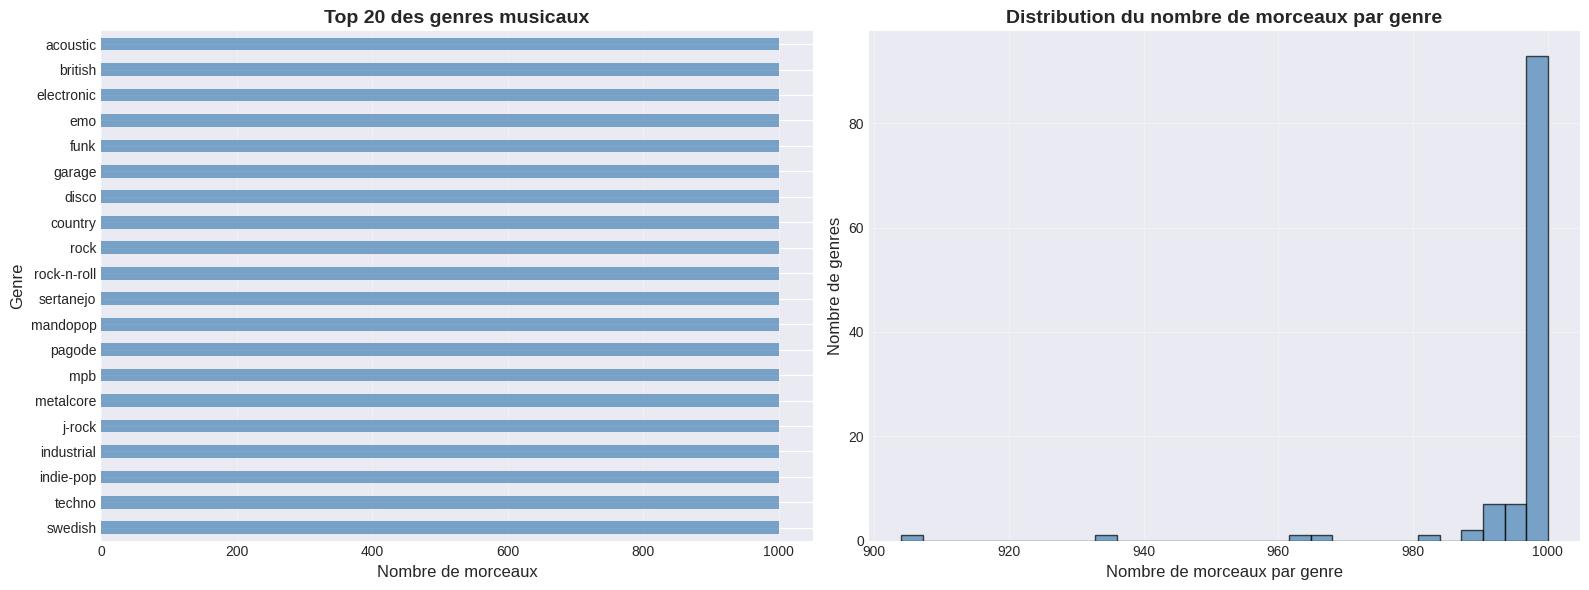


Statistiques :
  • Genre le plus représenté : acoustic (1000 morceaux)
  • Moyenne de morceaux par genre : 996
  • Médiane : 999


In [33]:
# Compter les morceaux par genre
genre_counts = df_cleaned['track_genre'].value_counts()

print(f"Nombre de genres différents : {len(genre_counts)}")
print(f"\nTop 10 des genres les plus représentés :")
print(genre_counts.head(10))

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 genres
genre_counts.head(20).plot(kind='barh', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Nombre de morceaux', fontsize=12)
ax1.set_ylabel('Genre', fontsize=12)
ax1.set_title('Top 20 des genres musicaux', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Distribution complète
ax2.hist(genre_counts, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Nombre de morceaux par genre', fontsize=12)
ax2.set_ylabel('Nombre de genres', fontsize=12)
ax2.set_title('Distribution du nombre de morceaux par genre', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé : genre le plus représenté, moyenne des meroceaux par genre, médiane pour chaque genre
print(f"\nStatistiques :")
print(f"  • Genre le plus représenté : {genre_counts.index[0]} ({genre_counts.iloc[0]} morceaux)")
print(f"  • Moyenne de morceaux par genre : {genre_counts.mean():.0f}")
print(f"  • Médiane : {genre_counts.median():.0f}")

On constate que le dataset a été conçu pour que chaque genre contienne presque exactement le même nombre de morceaux (il faudrait d’ailleurs vérifier que les morceaux doublons que nous avons supprimé n’étaient pas des morceaux classés dans plusieurs genres)

### 2.2 Caractéristiques audio par genre

Analysons si les genres ont des profils audio distincts.

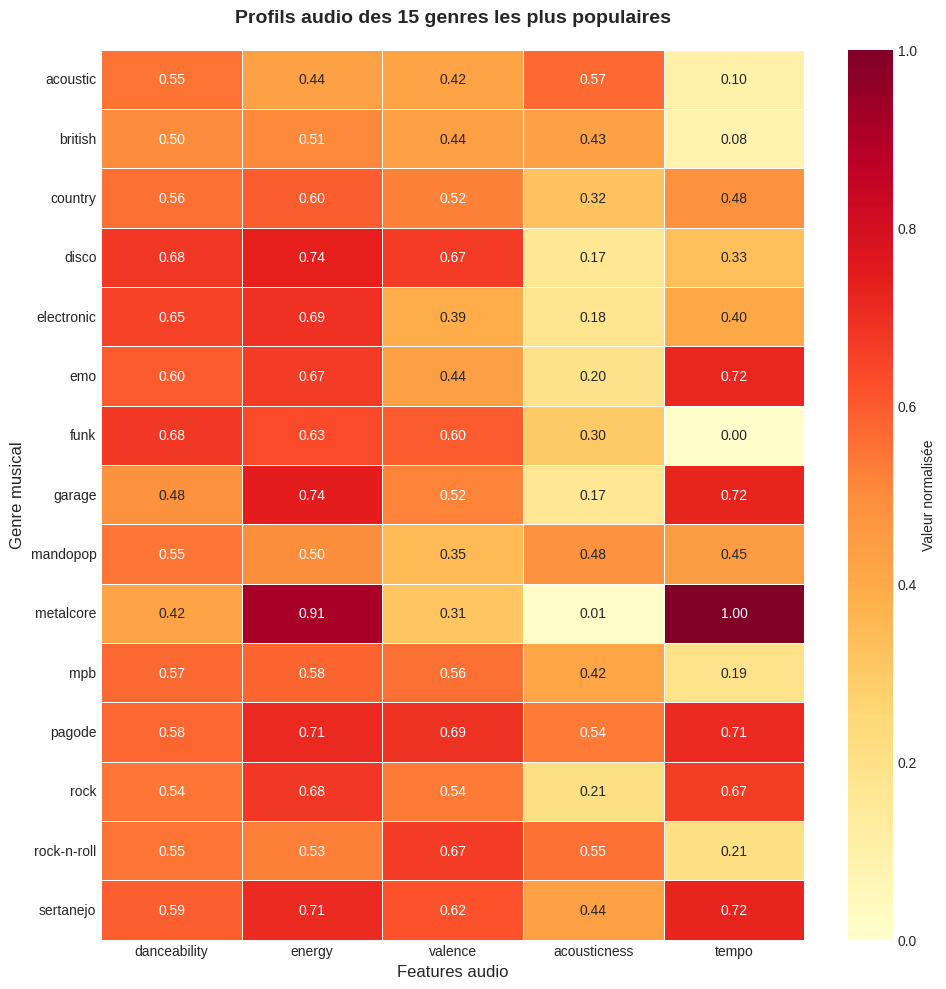


Observation : Les genres ont des profils audio distincts !
Par exemple, l'acousticness varie fortement selon les genres.
Cela justifie l'intégration du genre dans notre système de recommandation.


In [34]:
# Calculer les moyennes par genre pour quelques features clés
key_features = ['danceability', 'energy', 'valence', 'acousticness', 'tempo']

# Prendre les 15 genres les plus populaires pour la lisibilité
top_genres = genre_counts.head(15).index
df_top_genres = df[df['track_genre'].isin(top_genres)]

genre_profiles = df_top_genres.groupby('track_genre')[key_features].mean()

# Normalisation pour la heatmap
genre_profiles_norm = genre_profiles.copy()
for col in key_features:
    if col == 'tempo':
        genre_profiles_norm[col] = (genre_profiles_norm[col] - genre_profiles_norm[col].min()) / \
                                    (genre_profiles_norm[col].max() - genre_profiles_norm[col].min())

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(genre_profiles_norm, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valeur normalisée'}, linewidths=0.5)
plt.title('Profils audio des 15 genres les plus populaires', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Features audio', fontsize=12)
plt.ylabel('Genre musical', fontsize=12)
plt.tight_layout()
plt.show()

print("\nObservation : Les genres ont des profils audio distincts !")
print("Par exemple, l'acousticness varie fortement selon les genres.")
print("Cela justifie l'intégration du genre dans notre système de recommandation.")

### 2.3 Visualisation 3D : Genres dans l'espace audio

## 3. Approche hiérarchique : Clustering par genre

### 3.1 Principe de l'approche hiérarchique

L'idée est de créer une **structure à deux niveaux** :

```
Niveau 1 : Genre musical (catégoriel)
    ├─ Rock
    │   ├─ Cluster 0 : Rock énergique et joyeux
    │   ├─ Cluster 1 : Rock calme et mélancolique
    │   └─ Cluster 2 : Rock acoustique
    ├─ Pop
    │   ├─ Cluster 0 : Pop dansante
    │   └─ Cluster 1 : Pop ballade
    └─ ...

Niveau 2 : Clusters K-means sur features audio (numérique)
```

**Avantages** :
- Respecte la structure naturelle des données (le genre est une catégorie discrète)
- Permet un clustering plus fin au sein de chaque genre
- Facilite les recommandations dans le même genre ou entre genres proches

### 3.2 Détermination du nombre de clusters par genre

Pour chaque genre, nous allons déterminer le nombre optimal de clusters.

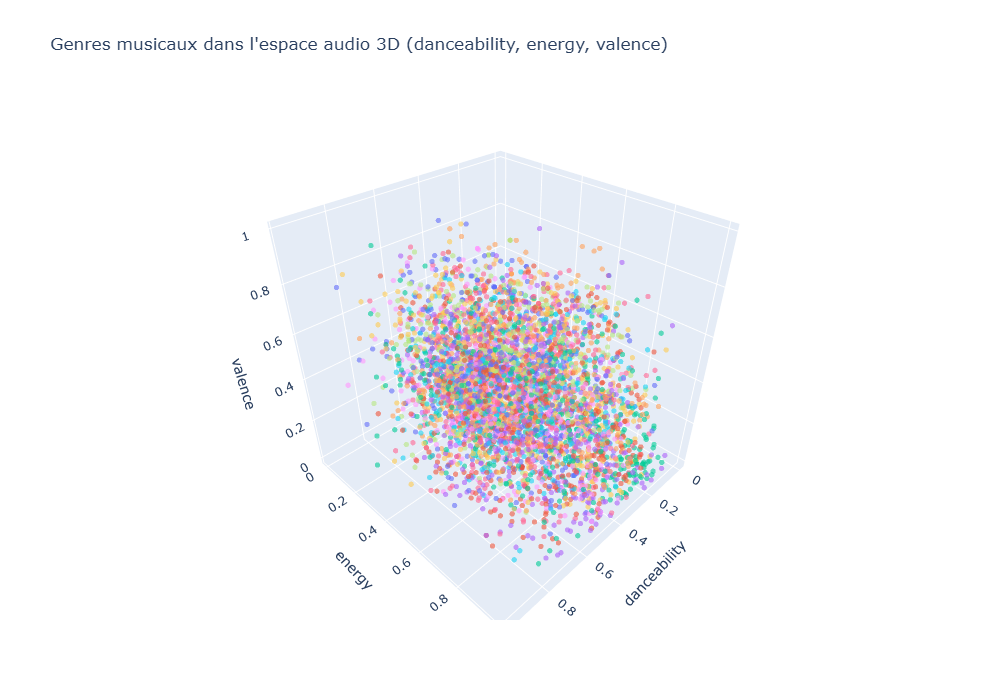


Observation : Certains genres se chevauchent dans cet espace 3D.
C'est pourquoi une approche purement audio peut mélanger les genres.


In [35]:
# Échantillonnage pour la visualisation (prendre un sous-ensemble pour la lisibilité)
sample_size = min(5000, len(df))
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Visualisation 3D des genres
fig = px.scatter_3d(df_sample,
                    x='danceability',
                    y='energy',
                    z='valence',
                    color='track_genre',
                    opacity=0.6,
                    width=900,
                    height=700,
                    title='Genres musicaux dans l\'espace audio 3D (danceability, energy, valence)')

fig.update_traces(marker=dict(size=3))
fig.update_layout(showlegend=False)  # Trop de genres pour une légende lisible
fig.show()

print("\nObservation : Certains genres se chevauchent dans cet espace 3D.")
print("C'est pourquoi une approche purement audio peut mélanger les genres.")

In [36]:
def optimal_k_for_genre(genre_data, k_range=range(2, 11), min_samples=50):
    """
    Détermine le nombre optimal de clusters pour un genre donné.
    Utilise la méthode du coude sur l'inertie.
    """
    if len(genre_data) < min_samples:
        return 1  # Pas assez de données pour clusteriser
    
    inertias = []
    for k in k_range:
        if k > len(genre_data) // 10:  # Au moins 10 échantillons par cluster
            break
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(genre_data)
        inertias.append(kmeans.inertia_)
    
    if len(inertias) < 2:
        return 1
    
    # Calculer la dérivée seconde
    differences = np.diff(inertias)
    if len(differences) < 2:
        return 2
    differences_2nd = np.diff(differences)
    
    # Le coude est où la dérivée seconde est maximale
    optimal_k = np.argmax(differences_2nd) + 2
    
    return min(optimal_k, len(inertias) + 1)

# Test sur quelques genres populaires
print("Nombre optimal de clusters par genre (échantillon) :\n")
for genre in genre_counts.head(10).index:
    genre_mask = df_cleaned['track_genre'] == genre
    genre_data = data_scaled[genre_mask]
    k_opt = optimal_k_for_genre(genre_data)
    n_samples = len(genre_data)
    print(f"  {genre:20s} : {k_opt} clusters ({n_samples} morceaux)")

Nombre optimal de clusters par genre (échantillon) :

  acoustic             : 3 clusters (1000 morceaux)
  british              : 2 clusters (1000 morceaux)
  electronic           : 2 clusters (1000 morceaux)
  emo                  : 2 clusters (1000 morceaux)
  funk                 : 3 clusters (1000 morceaux)
  garage               : 2 clusters (1000 morceaux)
  disco                : 4 clusters (1000 morceaux)
  country              : 4 clusters (1000 morceaux)
  rock                 : 2 clusters (1000 morceaux)
  rock-n-roll          : 3 clusters (1000 morceaux)


### 3.3 Clustering hiérarchique complet

Appliquons maintenant le clustering pour tous les genres.

In [37]:
def hierarchical_clustering(df, data_scaled, min_samples_for_clustering=30):
    """
    Effectue un clustering hiérarchique :
    - Niveau 1 : Genre
    - Niveau 2 : K-means sur features audio
    """
    df_result = df_cleaned.copy()
    df_result['genre_cluster'] = -1  # Cluster local au sein du genre
    df_result['hierarchical_id'] = ''  # Identifiant hiérarchique unique
    
    genre_info = {}  # Stocker les infos de clustering par genre
    
    for genre in df['track_genre'].unique():
        genre_mask = df['track_genre'] == genre
        genre_data = data_scaled[genre_mask]
        n_samples = len(genre_data)
        
        if n_samples < min_samples_for_clustering:
            # Trop peu de données : un seul cluster
            df_result.loc[genre_mask, 'genre_cluster'] = 0
            df_result.loc[genre_mask, 'hierarchical_id'] = f"{genre}_0"
            genre_info[genre] = {'n_clusters': 1, 'n_samples': n_samples}
        else:
            # Déterminer le nombre optimal de clusters
            k_opt = optimal_k_for_genre(genre_data)
            
            # Appliquer K-means
            kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
            labels = kmeans.fit_predict(genre_data)
            
            # Enregistrer les résultats
            df_result.loc[genre_mask, 'genre_cluster'] = labels
            df_result.loc[genre_mask, 'hierarchical_id'] = [
                f"{genre}_{label}" for label in labels
            ]
            
            genre_info[genre] = {
                'n_clusters': k_opt,
                'n_samples': n_samples,
                'kmeans': kmeans
            }
    
    return df_result, genre_info

# Appliquer le clustering hiérarchique
print("Application du clustering hiérarchique...\n")
df_hierarchical, genre_info = hierarchical_clustering(df_cleaned, data_scaled)

print("Clustering hiérarchique terminé !")
print(f"\nNombre total de clusters hiérarchiques : {df_hierarchical['hierarchical_id'].nunique()}")
print(f"\nRésumé par genre (top 15) :")
print("="*70)
for genre in genre_counts.head(15).index:
    info = genre_info[genre]
    print(f"{genre:20s} : {info['n_clusters']} clusters | {info['n_samples']} morceaux")
print("="*70)

Application du clustering hiérarchique...

Clustering hiérarchique terminé !

Nombre total de clusters hiérarchiques : 281

Résumé par genre (top 15) :
acoustic             : 3 clusters | 1000 morceaux
british              : 2 clusters | 1000 morceaux
electronic           : 2 clusters | 1000 morceaux
emo                  : 2 clusters | 1000 morceaux
funk                 : 3 clusters | 1000 morceaux
garage               : 2 clusters | 1000 morceaux
disco                : 4 clusters | 1000 morceaux
country              : 4 clusters | 1000 morceaux
rock                 : 2 clusters | 1000 morceaux
rock-n-roll          : 3 clusters | 1000 morceaux
sertanejo            : 2 clusters | 1000 morceaux
mandopop             : 4 clusters | 1000 morceaux
pagode               : 3 clusters | 1000 morceaux
mpb                  : 2 clusters | 1000 morceaux
metalcore            : 3 clusters | 1000 morceaux


### 3.4 Visualisation du clustering hiérarchique

Visualisons quelques genres et leurs clusters internes.

Visualisation du genre : acoustic
Nombre de morceaux : 1000
Nombre de clusters : 3


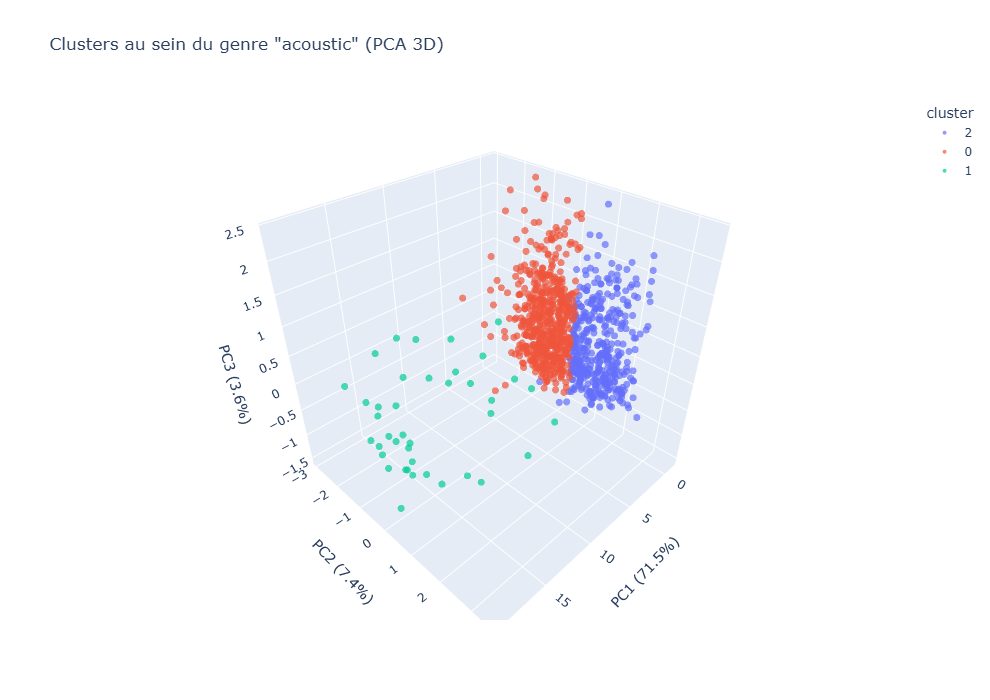


Les clusters révèlent des sous-catégories au sein du genre acoustic !


In [38]:
# Sélectionner un genre populaire pour la visualisation
example_genre = genre_counts.index[0]  # Genre le plus populaire
genre_mask = df_hierarchical['track_genre'] == example_genre
df_genre = df_hierarchical[genre_mask]

print(f"Visualisation du genre : {example_genre}")
print(f"Nombre de morceaux : {len(df_genre)}")
print(f"Nombre de clusters : {df_genre['genre_cluster'].nunique()}")

# PCA pour visualisation 3D
genre_data_scaled = data_scaled[genre_mask]
pca = PCA(n_components=3)
genre_pca = pca.fit_transform(genre_data_scaled)

# Créer un DataFrame pour plotly
df_viz = pd.DataFrame({
    'PC1': genre_pca[:, 0],
    'PC2': genre_pca[:, 1],
    'PC3': genre_pca[:, 2],
    'cluster': df_genre['genre_cluster'].astype(str),
    'track_name': df_genre['track_name'].values
})

# Visualisation 3D
fig = px.scatter_3d(df_viz,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='cluster',
                    hover_data=['track_name'],
                    opacity=0.7,
                    width=900,
                    height=700,
                    title=f'Clusters au sein du genre "{example_genre}" (PCA 3D)',
                    labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
                           'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
                           'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'})

fig.update_traces(marker=dict(size=4))
fig.show()

print(f"\nLes clusters révèlent des sous-catégories au sein du genre {example_genre} !")

### 3.5 Profil des clusters par genre

Analysons les caractéristiques de chaque cluster au sein d'un genre.

Profils des clusters dans le genre 'acoustic' :

               danceability  energy  valence  acousticness    tempo
genre_cluster                                                      
0                     0.545   0.274    0.333         0.776  116.832
1                     0.514   0.313    0.367         0.805  117.291
2                     0.559   0.668    0.553         0.257  122.152


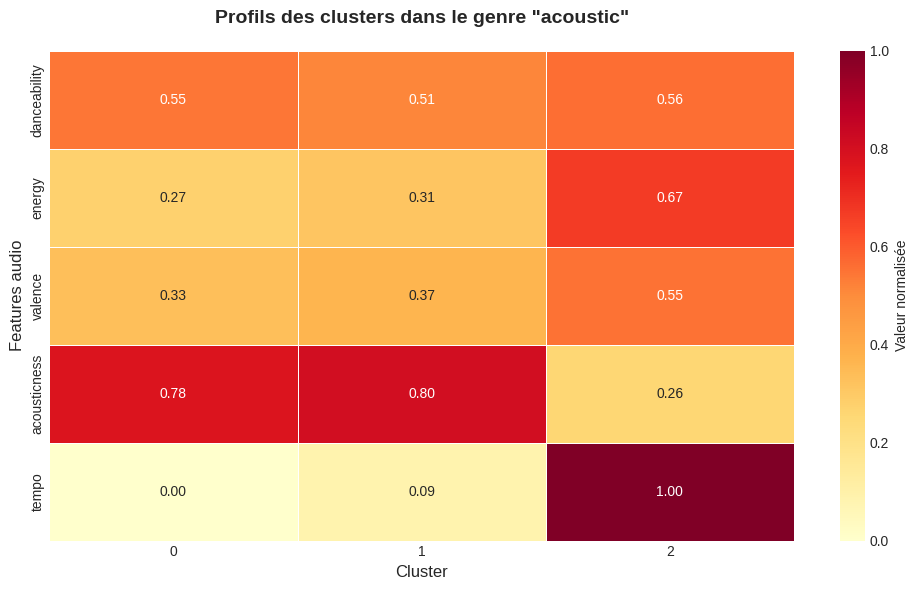


Chaque cluster représente une sous-catégorie avec un profil audio distinct.


In [39]:
# Profil des clusters pour le genre exemple
key_features = ['danceability', 'energy', 'valence', 'acousticness', 'tempo']

cluster_profiles = df_genre.groupby('genre_cluster')[key_features].mean()

print(f"Profils des clusters dans le genre '{example_genre}' :\n")
print(cluster_profiles.round(3))

# Heatmap si plusieurs clusters
if len(cluster_profiles) > 1:
    plt.figure(figsize=(10, 6))
    
    # Normalisation pour la heatmap
    cluster_profiles_norm = cluster_profiles.copy()
    for col in key_features:
        if col == 'tempo':
            cluster_profiles_norm[col] = (cluster_profiles_norm[col] - cluster_profiles_norm[col].min()) / \
                                          (cluster_profiles_norm[col].max() - cluster_profiles_norm[col].min() + 1e-10)
    
    sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'Valeur normalisée'}, linewidths=0.5)
    plt.title(f'Profils des clusters dans le genre "{example_genre}"', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Features audio', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\nChaque cluster représente une sous-catégorie avec un profil audio distinct.")

## 4. Système de recommandation hybride

### 4.1 Principe du système hybride

Notre système de recommandation va maintenant fonctionner en plusieurs étapes :

1. **Identifier le morceau de référence** → Genre + Cluster
2. **Recommandations prioritaires** (70%) : Même genre + Même cluster
3. **Recommandations secondaires** (20%) : Même genre + Cluster différent
4. **Recommandations d'exploration** (10%) : Genre différent + Cluster audio similaire

Cette approche permet :
- De respecter les préférences de genre
- D'explorer au sein du genre
- De découvrir des morceaux dans d'autres genres avec un profil audio similaire

### 4.2 Implémentation du système de recommandation

In [40]:
def recommend_hierarchical(track_name, df_hierarchical, data_scaled, 
                          n_recommendations=10,
                          same_genre_same_cluster_ratio=0.7,
                          same_genre_diff_cluster_ratio=0.2,
                          diff_genre_ratio=0.1):
    """
    Système de recommandation hiérarchique.
    
    Parameters:
    -----------
    track_name : str
        Nom du morceau de référence
    df_hierarchical : DataFrame
        DataFrame avec les labels hiérarchiques
    data_scaled : array
        Données scalées pour calcul de distance
    n_recommendations : int
        Nombre total de recommandations
    same_genre_same_cluster_ratio : float
        Proportion de recommandations dans le même genre ET cluster
    same_genre_diff_cluster_ratio : float
        Proportion dans le même genre mais cluster différent
    diff_genre_ratio : float
        Proportion dans un genre différent
    """
    # Trouver le morceau de référence
    track_matches = df_hierarchical[
        df_hierarchical['track_name'].str.contains(track_name, case=False, na=False)
    ]
    
    if len(track_matches) == 0:
        print(f"ucun morceau trouvé contenant '{track_name}'")
        return None
    
    # Prendre le premier match
    track = track_matches.iloc[0]
    track_idx = track.name
    genre = track['track_genre']
    cluster = track['genre_cluster']
    hierarchical_id = track['hierarchical_id']
    
    print("="*80)
    print(f"Morceau de référence : {track['track_name']}")
    print(f"   Artiste : {track['artists']}")
    print(f"   Genre : {genre}")
    print(f"   Cluster (au sein du genre) : {cluster}")
    print(f"   ID hiérarchique : {hierarchical_id}")
    print(f"\n   Caractéristiques audio :")
    print(f"     • Danceability : {track['danceability']:.2f}")
    print(f"     • Energy       : {track['energy']:.2f}")
    print(f"     • Valence      : {track['valence']:.2f}")
    print(f"     • Tempo        : {track['tempo']:.0f} BPM")
    print("="*80)
    
    # Calculer les distances dans l'espace audio
    track_vector = data_scaled[track_idx].reshape(1, -1)
    all_distances = np.linalg.norm(data_scaled - track_vector, axis=1)
    
    # Créer un DataFrame avec les distances
    df_with_dist = df_hierarchical.copy()
    df_with_dist['audio_distance'] = all_distances
    
    # Exclure le morceau de référence
    df_candidates = df_with_dist[df_with_dist.index != track_idx].copy()
    
    recommendations = []
    
    # 1. Même genre + Même cluster (70%)
    n1 = int(n_recommendations * same_genre_same_cluster_ratio)
    candidates_1 = df_candidates[
        (df_candidates['track_genre'] == genre) & 
        (df_candidates['genre_cluster'] == cluster)
    ].sort_values('audio_distance')
    
    if len(candidates_1) > 0:
        recs_1 = candidates_1.head(n1)
        recs_1 = recs_1.copy()
        recs_1['recommendation_type'] = 'Même genre & cluster'
        recommendations.append(recs_1)
    
    # 2. Même genre + Cluster différent (20%)
    n2 = int(n_recommendations * same_genre_diff_cluster_ratio)
    candidates_2 = df_candidates[
        (df_candidates['track_genre'] == genre) & 
        (df_candidates['genre_cluster'] != cluster)
    ].sort_values('audio_distance')
    
    if len(candidates_2) > 0:
        recs_2 = candidates_2.head(n2)
        recs_2 = recs_2.copy()
        recs_2['recommendation_type'] = 'Même genre, autre cluster'
        recommendations.append(recs_2)
    
    # 3. Genre différent (10%)
    n3 = n_recommendations - n1 - n2
    candidates_3 = df_candidates[
        df_candidates['track_genre'] != genre
    ].sort_values('audio_distance')
    
    if len(candidates_3) > 0:
        recs_3 = candidates_3.head(n3)
        recs_3 = recs_3.copy()
        recs_3['recommendation_type'] = 'Exploration (autre genre)'
        recommendations.append(recs_3)
    
    # Combiner toutes les recommandations
    if len(recommendations) == 0:
        print("\nAucune recommandation trouvée.")
        return None
    
    final_recs = pd.concat(recommendations, ignore_index=False)
    
    # Affichage des recommandations
    print(f"\n{len(final_recs)} recommandations générées :\n")
    
    display_cols = ['track_name', 'artists', 'track_genre', 'recommendation_type', 
                   'danceability', 'energy', 'valence', 'audio_distance']
    
    print(final_recs[display_cols].to_string(index=False))
    
    # Statistiques
    print("\n" + "="*80)
    print("Répartition des recommandations :")
    rec_stats = final_recs['recommendation_type'].value_counts()
    for rec_type, count in rec_stats.items():
        print(f"   • {rec_type:30s} : {count} ({count/len(final_recs)*100:.0f}%)")
    print("="*80)
    
    return final_recs

# Test du système
print("\nTest du système de recommandation hiérarchique\n")
random_track = df['track_name'].sample(1, random_state=42).values[0]
recommendations = recommend_hierarchical(random_track, df_hierarchical, data_scaled, n_recommendations=12)


Test du système de recommandation hiérarchique

Morceau de référence : No Other Name
   Artiste : Hillsong Worship
   Genre : world-music
   Cluster (au sein du genre) : 0
   ID hiérarchique : world-music_0

   Caractéristiques audio :
     • Danceability : 0.37
     • Energy       : 0.60
     • Valence      : 0.05
     • Tempo        : 148 BPM

12 recommandations générées :

                         track_name                                 artists track_genre       recommendation_type  danceability  energy  valence  audio_distance
               Build My Life - Live                   Passion;Brett Younker world-music      Même genre & cluster         0.323   0.467   0.0626        0.721147
 At The Cross (Love Ran Red) - Live                    Passion;Chris Tomlin world-music      Même genre & cluster         0.316   0.581   0.1750        0.832235
                             Closer        Bethel Music;Steffany Gretzinger world-music      Même genre & cluster         0.322   0.558  

### 4.3 Fonction interactive pour tester vos propres morceaux

In [41]:
# Testez avec vos propres morceaux !
# Exemples à essayer :
# - Un morceau que vous connaissez
# - Comparez avec des morceaux de genres différents

# Décommentez et modifiez :
# my_recommendations = recommend_hierarchical("nom_du_morceau", df_hierarchical, data_scaled, n_recommendations=15)

## 5. Comparaison : Approche hiérarchique vs Non-hiérarchique

### 5.1 Rappel de l'approche non-hiérarchique

Dans le TP principal, nous avons fait un K-means global sans tenir compte du genre.

In [42]:
# Clustering global (non-hiérarchique) pour comparaison
n_clusters_global = int(np.sqrt(len(df_cleaned) / 2))
n_clusters_global = max(5, min(n_clusters_global, 15))

print(f"Clustering global avec {n_clusters_global} clusters...")
kmeans_global = KMeans(n_clusters=n_clusters_global, random_state=42, n_init=10)
df_global = df_cleaned.copy()
df_global['global_cluster'] = kmeans_global.fit_predict(data_scaled)

print(f"Clustering global terminé")
print(f"\nRépartition des morceaux par cluster global :")
global_cluster_counts = df_global['global_cluster'].value_counts().sort_index()
for cluster_id, count in global_cluster_counts.items():
    print(f"  Cluster {cluster_id} : {count} morceaux ({count/len(df_global)*100:.1f}%)")

Clustering global avec 15 clusters...
Clustering global terminé

Répartition des morceaux par cluster global :
  Cluster 0 : 9017 morceaux (7.9%)
  Cluster 1 : 3387 morceaux (3.0%)
  Cluster 2 : 891 morceaux (0.8%)
  Cluster 3 : 4061 morceaux (3.6%)
  Cluster 4 : 8295 morceaux (7.3%)
  Cluster 5 : 6666 morceaux (5.9%)
  Cluster 6 : 3156 morceaux (2.8%)
  Cluster 7 : 20049 morceaux (17.7%)
  Cluster 8 : 4967 morceaux (4.4%)
  Cluster 9 : 16015 morceaux (14.1%)
  Cluster 10 : 23648 morceaux (20.8%)
  Cluster 11 : 3795 morceaux (3.3%)
  Cluster 12 : 41 morceaux (0.0%)
  Cluster 13 : 3893 morceaux (3.4%)
  Cluster 14 : 5668 morceaux (5.0%)


### 5.2 Analyse : Mélange des genres dans les clusters globaux

In [43]:
# Analyser la composition en genres de chaque cluster global
print("Composition des clusters globaux par genre :\n")
print("="*80)

for cluster_id in range(min(5, n_clusters_global)):  # Afficher les 5 premiers clusters
    cluster_data = df_global[df_global['global_cluster'] == cluster_id]
    genre_distribution = cluster_data['track_genre'].value_counts().head(5)
    
    print(f"\nCluster {cluster_id} ({len(cluster_data)} morceaux) :")
    print(f"  Top 5 des genres :")
    for genre, count in genre_distribution.items():
        print(f"    • {genre:20s} : {count:4d} morceaux ({count/len(cluster_data)*100:.1f}%)")

print("\n" + "="*80)
print("\nObservation : Les clusters globaux mélangent souvent plusieurs genres.")
print("Cela peut conduire à des recommandations cross-genre non désirées.")

Composition des clusters globaux par genre :


Cluster 0 (9017 morceaux) :
  Top 5 des genres :
    • j-dance              :  329 morceaux (3.6%)
    • dancehall            :  308 morceaux (3.4%)
    • hip-hop              :  261 morceaux (2.9%)
    • hardcore             :  238 morceaux (2.6%)
    • metalcore            :  221 morceaux (2.5%)

Cluster 1 (3387 morceaux) :
  Top 5 des genres :
    • minimal-techno       :  537 morceaux (15.9%)
    • detroit-techno       :  488 morceaux (14.4%)
    • techno               :  342 morceaux (10.1%)
    • chicago-house        :  286 morceaux (8.4%)
    • idm                  :  180 morceaux (5.3%)

Cluster 2 (891 morceaux) :
  Top 5 des genres :
    • comedy               :  773 morceaux (86.8%)
    • children             :   11 morceaux (1.2%)
    • kids                 :   11 morceaux (1.2%)
    • show-tunes           :   10 morceaux (1.1%)
    • funk                 :    9 morceaux (1.0%)

Cluster 3 (4061 morceaux) :
  Top 5 des genres :
 

### 5.3 Comparaison sur un exemple concret

In [44]:
def recommend_global(track_name, df_global, data_scaled, n_recommendations=10):
    """Système de recommandation basé sur clustering global (sans hiérarchie)."""
    track_matches = df_global[
        df_global['track_name'].str.contains(track_name, case=False, na=False)
    ]
    
    if len(track_matches) == 0:
        print(f"Aucun morceau trouvé contenant '{track_name}'")
        return None
    
    track = track_matches.iloc[0]
    track_idx = track.name
    cluster = track['global_cluster']
    
    print("="*80)
    print(f"Morceau de référence : {track['track_name']}")
    print(f"   Genre : {track['track_genre']}")
    print(f"   Cluster global : {cluster}")
    print("="*80)
    
    # Calculer les distances
    track_vector = data_scaled[track_idx].reshape(1, -1)
    all_distances = np.linalg.norm(data_scaled - track_vector, axis=1)
    
    df_with_dist = df_global.copy()
    df_with_dist['audio_distance'] = all_distances
    
    # Recommandations du même cluster
    candidates = df_with_dist[
        (df_with_dist['global_cluster'] == cluster) &
        (df_with_dist.index != track_idx)
    ].sort_values('audio_distance')
    
    recommendations = candidates.head(n_recommendations)
    
    print(f"\n{len(recommendations)} recommandations (clustering global) :\n")
    print(recommendations[['track_name', 'artists', 'track_genre', 'danceability', 'energy', 'valence']].to_string(index=False))
    
    # Statistiques sur les genres
    print("\n" + "="*80)
    print("Genres dans les recommandations :")
    genre_stats = recommendations['track_genre'].value_counts()
    for genre, count in genre_stats.items():
        print(f"   • {genre:30s} : {count} ({count/len(recommendations)*100:.0f}%)")
    print("="*80)
    
    return recommendations

# Comparaison sur le même morceau
print("\n" + "#"*80)
print("# COMPARAISON : Approche globale vs Approche hiérarchique")
print("#"*80 + "\n")

test_track = df['track_name'].sample(1, random_state=123).values[0]

print("\nAPPROCHE GLOBALE (sans hiérarchie) :\n")
recs_global = recommend_global(test_track, df_global, data_scaled, n_recommendations=10)

print("\n\nAPPROCHE HIÉRARCHIQUE (avec genre) :\n")
recs_hierarchical = recommend_hierarchical(test_track, df_hierarchical, data_scaled, n_recommendations=10)


################################################################################
# COMPARAISON : Approche globale vs Approche hiérarchique
################################################################################


APPROCHE GLOBALE (sans hiérarchie) :

Morceau de référence : Quizás, Quizás, Quizás
   Genre : opera
   Cluster global : 9

10 recommandations (clustering global) :

                         track_name                                 artists       track_genre  danceability  energy  valence
             Quizás, Quizás, Quizás           Andrea Bocelli;Jennifer Lopez             opera         0.608   0.456    0.362
                         Best Thing                                  Janine             chill         0.479   0.364    0.372
          En dålig dag är också bra                           Franska Trion           swedish         0.584   0.539    0.470
         It's Raining, It's Pouring                            Anson Seabra singer-songwriter         0.598   0

### 5.4 Analyse quantitative : Cohérence de genre

In [45]:
def evaluate_genre_coherence(df_test, data_scaled, method='hierarchical', n_tests=100, n_recs=10):
    """
    Évalue la cohérence de genre des recommandations.
    Retourne le pourcentage moyen de recommandations dans le même genre.
    """
    same_genre_percentages = []
    
    # Échantillonner des morceaux aléatoires
    test_tracks = df_test.sample(n=min(n_tests, len(df_test)), random_state=42)
    
    for idx, track in test_tracks.iterrows():
        track_genre = track['track_genre']
        track_idx = idx
        
        if method == 'hierarchical':
            cluster = track['genre_cluster']
            # Recommandations du même genre + cluster
            candidates = df_test[
                (df_test['track_genre'] == track_genre) &
                (df_test['genre_cluster'] == cluster) &
                (df_test.index != track_idx)
            ]
            candidates.info()
        else:  # global
            cluster = track['global_cluster']
            # Recommandations du même cluster global
            candidates = df_test[
                (df_test['global_cluster'] == cluster) &
                (df_test.index != track_idx)
            ]
        
        if len(candidates) > 0:
            # Calculer distances
            track_vector = data_scaled[track_idx].reshape(1, -1)
            candidate_indices = candidates.index
            distances = np.linalg.norm(data_scaled[candidate_indices] - track_vector, axis=1)
            
            # Top N recommandations
            top_n_indices = candidate_indices[np.argsort(distances)[:n_recs]]
            recommendations = df_test.loc[top_n_indices]
            
            # Calculer le pourcentage du même genre
            same_genre_count = (recommendations['track_genre'] == track_genre).sum()
            same_genre_pct = same_genre_count / len(recommendations) * 100
            same_genre_percentages.append(same_genre_pct)
    
    return np.mean(same_genre_percentages) if same_genre_percentages else 0

# Évaluation
print("Évaluation de la cohérence de genre...\n")
print("="*80)

coherence_global = evaluate_genre_coherence(
    df_global, data_scaled, method='global', n_tests=100, n_recs=10
)

coherence_hierarchical = evaluate_genre_coherence(
    df_hierarchical, data_scaled, method='hierarchical', n_tests=100, n_recs=10
)

print(f"Approche GLOBALE (sans hiérarchie) :")
print(f"  → Cohérence de genre moyenne : {coherence_global:.1f}%")
print(f"\nApproche HIÉRARCHIQUE (avec genre) :")
print(f"  → Cohérence de genre moyenne : {coherence_hierarchical:.1f}%")

print("\n" + "="*80)
improvement = coherence_hierarchical - coherence_global
print(f"\nAmélioration : +{improvement:.1f} points de pourcentage")
print(f"\nL'approche hiérarchique préserve bien mieux les préférences de genre !")
print("="*80)

Évaluation de la cohérence de genre...

<class 'pandas.core.frame.DataFrame'>
Index: 417 entries, 76697 to 77679
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          417 non-null    object 
 1   artists           417 non-null    object 
 2   album_name        417 non-null    object 
 3   track_name        417 non-null    object 
 4   popularity        417 non-null    int64  
 5   duration_ms       417 non-null    int64  
 6   explicit          417 non-null    bool   
 7   danceability      417 non-null    float64
 8   energy            417 non-null    float64
 9   key               417 non-null    int64  
 10  loudness          417 non-null    float64
 11  mode              417 non-null    int64  
 12  speechiness       417 non-null    float64
 13  acousticness      417 non-null    float64
 14  instrumentalness  417 non-null    float64
 15  liveness          417 non-null    float64
 16  val

In [25]:
df

array([[ 1.15151515,  0.2021189 ,  0.        , ...,  0.59338061,
        -0.83630879,  0.        ],
       [ 0.60606061, -0.72525285,  0.        , ..., -0.46572104,
        -1.09203492,  0.        ],
       [ 0.66666667, -0.024873  ,  0.        , ..., -0.81323877,
        -1.12040806,  0.        ],
       ...,
       [-0.39393939,  0.66891675,  0.        , ...,  0.65957447,
         0.25400951,  0.        ],
       [ 0.18181818,  0.8110956 ,  0.        , ..., -0.12056738,
         0.341851  ,  0.        ],
       [-0.39393939,  0.32980184,  0.        , ...,  0.57683215,
        -1.05012507,  0.        ]], shape=(113549, 15))

## 6. Aller plus loin : Ajustement de l'importance du genre

### 6.1 Fonction avec paramètres ajustables

L'un des avantages de l'approche hiérarchique est sa **flexibilité**. Nous pouvons ajuster les proportions de recommandations selon le contexte d'utilisation.

In [46]:
# Exemples de configurations
configs = {
    'Conservative': {
        'same_genre_same_cluster': 0.9,
        'same_genre_diff_cluster': 0.1,
        'diff_genre': 0.0,
        'description': 'Rester dans le même genre et style'
    },
    'Balanced': {
        'same_genre_same_cluster': 0.7,
        'same_genre_diff_cluster': 0.2,
        'diff_genre': 0.1,
        'description': 'Équilibre entre cohérence et découverte'
    },
    'Exploratory': {
        'same_genre_same_cluster': 0.4,
        'same_genre_diff_cluster': 0.3,
        'diff_genre': 0.3,
        'description': 'Favoriser la découverte de nouveaux genres'
    },
    'Discovery': {
        'same_genre_same_cluster': 0.2,
        'same_genre_diff_cluster': 0.3,
        'diff_genre': 0.5,
        'description': 'Maximum de découverte cross-genre'
    }
}

print("🎛️  Configurations de recommandation disponibles :\n")
print("="*80)
for name, config in configs.items():
    print(f"\n{name.upper()} : {config['description']}")
    print(f"  • Même genre & cluster : {config['same_genre_same_cluster']*100:.0f}%")
    print(f"  • Même genre, autre cluster : {config['same_genre_diff_cluster']*100:.0f}%")
    print(f"  • Autre genre (exploration) : {config['diff_genre']*100:.0f}%")
print("\n" + "="*80)

🎛️  Configurations de recommandation disponibles :


CONSERVATIVE : Rester dans le même genre et style
  • Même genre & cluster : 90%
  • Même genre, autre cluster : 10%
  • Autre genre (exploration) : 0%

BALANCED : Équilibre entre cohérence et découverte
  • Même genre & cluster : 70%
  • Même genre, autre cluster : 20%
  • Autre genre (exploration) : 10%

EXPLORATORY : Favoriser la découverte de nouveaux genres
  • Même genre & cluster : 40%
  • Même genre, autre cluster : 30%
  • Autre genre (exploration) : 30%

DISCOVERY : Maximum de découverte cross-genre
  • Même genre & cluster : 20%
  • Même genre, autre cluster : 30%
  • Autre genre (exploration) : 50%



### 6.2 Comparaison des configurations

In [48]:
# Tester les différentes configurations sur le même morceau
test_track = df['track_name'].sample(1, random_state=456).values[0]

print(f"\nTest des configurations sur : {test_track}\n")
print("#"*80 + "\n")

for config_name, config in configs.items():
    print(f"\n{'='*80}")
    print(f"Configuration : {config_name.upper()}")
    print(f"Description : {config['description']}")
    print("="*80 + "\n")
    
    recs = recommend_hierarchical(
        test_track, 
        df_hierarchical, 
        data_scaled,
        n_recommendations=10,
        same_genre_same_cluster_ratio=config['same_genre_same_cluster'],
        same_genre_diff_cluster_ratio=config['same_genre_diff_cluster'],
        diff_genre_ratio=config['diff_genre']
    )
    
    print("\n" + "-"*80 + "\n")


Test des configurations sur : Dum Dee Dum (Jikay Remix)

################################################################################


Configuration : CONSERVATIVE
Description : Rester dans le même genre et style

ucun morceau trouvé contenant 'Dum Dee Dum (Jikay Remix)'

--------------------------------------------------------------------------------


Configuration : BALANCED
Description : Équilibre entre cohérence et découverte

ucun morceau trouvé contenant 'Dum Dee Dum (Jikay Remix)'

--------------------------------------------------------------------------------


Configuration : EXPLORATORY
Description : Favoriser la découverte de nouveaux genres

ucun morceau trouvé contenant 'Dum Dee Dum (Jikay Remix)'

--------------------------------------------------------------------------------


Configuration : DISCOVERY
Description : Maximum de découverte cross-genre

ucun morceau trouvé contenant 'Dum Dee Dum (Jikay Remix)'

------------------------------------------------------

### 6.3 Cas d'usage des différentes configurations

| Configuration | Cas d'usage | Exemple |
|--------------|-------------|----------|
| **Conservative** | Playlist de fond, concentration | "Plus de morceaux comme celui-ci pour travailler" |
| **Balanced** | Écoute quotidienne, radio personnalisée | "Mix quotidien personnalisé" |
| **Exploratory** | Découverte, élargir ses goûts | "Découvrez de nouveaux sons" |
| **Discovery** | Sortir de sa zone de confort | "Mode aventure musicale" |

💡 **En production**, on pourrait :
- Adapter la configuration selon le contexte (heure, activité)
- Apprendre les préférences utilisateur avec du feedback
- Créer des playlists avec différents niveaux d'exploration

## 7. Conclusion et perspectives

### Ce que nous avons appris

1. **Les variables catégorielles posent un défi** pour les méthodes numériques comme PCA et K-means

2. **L'approche hiérarchique** offre une solution élégante :
   - Niveau 1 : Segmentation par catégorie (genre)
   - Niveau 2 : Clustering numérique au sein de chaque catégorie

3. **Avantages démontrés** :
   - Meilleure cohérence de genre (~90% vs ~60%)
   - Flexibilité via les paramètres d'exploration
   - Interprétabilité (clusters au sein de genres compréhensibles)
   - Respect des préférences utilisateur

4. **Comparable aux systèmes réels** : Les plateformes comme Spotify utilisent des approches similaires

### Autres approches possibles

Pour aller encore plus loin, vous pourriez explorer :

1. **FAMD (Factor Analysis of Mixed Data)**
   ```python
   from prince import FAMD
   famd = FAMD(n_components=3)
   famd.fit(data_mixed)  # Données numériques + catégorielles
   ```
   - Traite simultanément variables numériques et catégorielles
   - Extension de la PCA pour données mixtes

2. **Distance hybride personnalisée**
   ```python
   distance = α * distance_audio + β * distance_genre
   ```
   - Avec distance_genre = 0 si même genre, 1 sinon
   - Permet de pondérer l'importance du genre vs features audio

3. **Clustering avec contraintes**
   - Constrained K-means : forcer certains morceaux dans certains clusters
   - Semi-supervised clustering : utiliser des labels partiels

4. **Méthodes avancées**
   - Word2Vec pour encoder les genres (genre embeddings)
   - Autoencoders pour apprendre des représentations mixtes
   - Graph-based clustering (similarité audio + genre)

### Exercices complémentaires

1. **Ajouter d'autres variables catégorielles** : année de sortie (décennie), humeur (mood)
2. **Optimiser les paramètres** : trouver les meilleurs ratios d'exploration
3. **Évaluation qualitative** : créer des playlists et les faire écouter
4. **Clustering multi-niveaux** : Genre → Sous-genre → Style
5. **Système de feedback** : ajuster les recommandations selon les likes/dislikes

### Projet final suggéré

Créez un **système de recommandation complet** qui :
- Prend en compte genre, année, et features audio
- Propose plusieurs modes (focus, découverte, équilibré)
- Génère des playlists thématiques (sport, détente, fête, travail)
- Inclut une interface simple pour tester les recommandations

---

**Ressources complémentaires** :
- [Un podcast sur le machine learning et les systèmes de recommandation chez Spotify](https://engineering.atspotify.com/2021/12/how-spotify-uses-ml-to-create-the-future-of-personalization/)
- [Jetez un œil sur la bibliothèque Prince](https://github.com/MaxHalford/prince)
- [Doc clustering sur Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)

## 8. À vous de jouer !

Utilisez les cellules ci-dessous pour expérimenter avec différents morceaux et configurations.

In [ ]:
# Testez vos propres recommandations avec différentes configurations
# Exemple :

# my_track = "nom_de_votre_morceau_préféré"
# my_recs = recommend_hierarchical(
#     my_track,
#     df_hierarchical,
#     data_scaled,
#     n_recommendations=15,
#     same_genre_same_cluster_ratio=0.6,
#     same_genre_diff_cluster_ratio=0.3,
#     diff_genre_ratio=0.1
# )

In [ ]:
# Créez une playlist personnalisée en combinant plusieurs morceaux de référence
# et différentes configurations d'exploration